In [ ]:
import lib.time_logger as TLOG
from lib.core import *
import os
import json
from collections import defaultdict
import pandas as pd
import numpy as np
from core import info, error, warning

DATA_PATH = os.path.join("data", "result", "")

def extract_setup_key(metadata):
    """Extract only the setup parameters from metadata, excluding strategies."""
    setup_params = {}
    for key, value in metadata.items():
        if key not in ['attacker_strategy', 'defender_strategy']:
            setup_params[key] = value
    return json.dumps(setup_params, sort_keys=True)

def create_strategy_matrix():
    """
    Group files by unique setups and create matrices of attacker vs defender strategies.
    """
    print(f"Reading JSON files from: {DATA_PATH}")
    
    # Check if directory exists
    if not os.path.exists(DATA_PATH):
        print(f"Directory {DATA_PATH} does not exist.")
        return {}
    
    # Data structures to store results by setup and strategies
    setups = {}  # Will store {setup_key: {(attacker, defender): [stats]}}
    
    # Collect all unique attacker and defender strategies
    all_attackers = set()
    all_defenders = set()
    
    # Process all JSON files
    for filename in os.listdir(DATA_PATH):
        if not filename.endswith(".json"):
            continue
            
        filepath = os.path.join(DATA_PATH, filename)
        
        # Skip empty files
        if os.path.getsize(filepath) == 0:
            print(f"File {filename} is empty. Skipping.")
            continue
            
        try:
            # Create TimeLogger instance and read the file
            logger = TLOG.TimeLogger(name=filename)
            logger.path = DATA_PATH
            logger.read_from_file(filename)
            
            # Get metadata
            metadata = logger.get_metadata()
            
            # Skip if missing critical metadata
            if 'attacker_strategy' not in metadata or 'defender_strategy' not in metadata:
                print(f"File {filename} is missing strategy information. Skipping.")
                continue
            
            # Extract setup key (everything except strategies)
            setup_key = extract_setup_key(metadata)
            
            # Extract strategy info
            attacker = metadata.get('attacker_strategy')
            defender = metadata.get('defender_strategy')
            
            # Add to our sets of all strategies
            all_attackers.add(attacker)
            all_defenders.add(defender)
            
            # Initialize setup entry if needed
            if setup_key not in setups:
                setups[setup_key] = {}
            
            # Get strategy pair key
            strategy_pair = (attacker, defender)
            
            # Extract summary records
            summary_records = logger.extract_summary()
            
            # If there are summary records, add them to the appropriate group
            if summary_records:
                for summary in summary_records:
                    # Check if it has the keys we're interested in
                    if any(key in summary for key in ['payoff', 'time', 'total_captures', 'total_tags']):
                        if strategy_pair not in setups[setup_key]:
                            setups[setup_key][strategy_pair] = []
                        setups[setup_key][strategy_pair].append(summary)
            
        except Exception as e:
            print(f"Error processing file {filename}: {str(e)}")
    
    # For each setup, calculate averages for each strategy pair
    results = {}
    
    for setup_key, strategy_data in setups.items():
        setup_dict = json.loads(setup_key)
        
        # Create a strategy matrix for this setup
        attackers = sorted(all_attackers)
        defenders = sorted(all_defenders)
        
        # Create a matrix for each stat
        payoff_matrix = pd.DataFrame(index=defenders, columns=attackers)
        time_matrix = pd.DataFrame(index=defenders, columns=attackers)
        captures_matrix = pd.DataFrame(index=defenders, columns=attackers)
        tags_matrix = pd.DataFrame(index=defenders, columns=attackers)
        
        # Fill the matrices
        for (attacker, defender), summaries in strategy_data.items():
            # Skip pairs that don't have summary data
            if not summaries:
                continue
                
            # Calculate averages
            
            # Print all the payoffs for debugging
            print(f"Payoffs for {defender} vs {attacker}: {[s.get('payoff', 0) for s in summaries]}")
            # Calculate the sum of each metric
            payoff_sum = sum(s.get('payoff', 0) for s in summaries if 'payoff' in s)
            time_sum = sum(s.get('time', 0) for s in summaries if 'time' in s)
            captures_sum = sum(s.get('total_captures', 0) for s in summaries if 'total_captures' in s)
            tags_sum = sum(s.get('total_tags', 0) for s in summaries if 'total_tags' in s)
            
            count = len(summaries)
            
            payoff_matrix.loc[defender, attacker] = round(payoff_sum / count, 2) if count > 0 else np.nan
            time_matrix.loc[defender, attacker] = round(time_sum / count, 2) if count > 0 else np.nan
            captures_matrix.loc[defender, attacker] = round(captures_sum / count, 2) if count > 0 else np.nan
            tags_matrix.loc[defender, attacker] = round(tags_sum / count, 2) if count > 0 else np.nan
        
        # Store results for this setup
        results[setup_key] = {
            'setup': setup_dict,
            'payoff_matrix': payoff_matrix,
            'time_matrix': time_matrix,
            'captures_matrix': captures_matrix,
            'tags_matrix': tags_matrix
        }
    
    return results, all_attackers, all_defenders

def display_wide_matrices(results):
    """
    Display matrices in wide format suitable for wide terminals.
    """
    # Set pandas to show full dataframes without truncation
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    pd.set_option('display.max_colwidth', 30)
    pd.set_option('display.expand_frame_repr', False)
    
    for setup_idx, (setup_key, data) in enumerate(results.items(), 1):
        print(f"\n{'='*120}")
        print(f"SETUP {setup_idx}:")
        print(f"{'='*120}")
        
        # Print setup details
        setup = data['setup']
        setup_str = " | ".join([f"{key}: {value}" for key, value in setup.items()])
        print(f"Game Configuration: {setup_str}")
        print('-' * 120)
        
        # Get matrices
        payoff = data['payoff_matrix']
        time = data['time_matrix']
        captures = data['captures_matrix']
        tags = data['tags_matrix']
        
        # Create a custom formatted matrix with all stats
        print("\nFULL STATISTICS MATRIX (Defender Strategies vs Attacker Strategies)")
        print('-' * 120)
        
        # Create a DataFrame with multi-line cell content
        combined_matrix = pd.DataFrame(index=payoff.index, columns=payoff.columns)
        
        for defender in payoff.index:
            for attacker in payoff.columns:
                p = payoff.loc[defender, attacker]
                t = time.loc[defender, attacker]
                c = captures.loc[defender, attacker]
                tag = tags.loc[defender, attacker]
                
                if pd.isna(p):
                    combined_matrix.loc[defender, attacker] = "N/A"
                else:
                    cell_value = (
                        f"Payoff: {p:.2f}|"
                        f"Time: {t:.2f}|"
                        f"Captures: {c:.2f}|"
                        f"Tags: {tag:.2f}    "
                    )
                    combined_matrix.loc[defender, attacker] = cell_value
        
        # Reset index to get defenders as a column
        formatted_matrix = combined_matrix.reset_index()
        formatted_matrix.columns = ["Defender"] + list(combined_matrix.columns)
        
        # Print with wide format
        print(formatted_matrix.to_string(index=False))
        
        # Now display individual matrices
        print("\nPAYOFF MATRIX")
        print('-' * 120)
        payoff_formatted = payoff.reset_index()
        payoff_formatted.columns = ["Defender"] + list(payoff.columns)
        print(payoff_formatted.to_string(index=False))
        
        print("\nTIME MATRIX")
        print('-' * 120)
        time_formatted = time.reset_index()
        time_formatted.columns = ["Defender"] + list(time.columns)
        print(time_formatted.to_string(index=False))
        
        print("\nCAPTURES MATRIX")
        print('-' * 120)
        captures_formatted = captures.reset_index()
        captures_formatted.columns = ["Defender"] + list(captures.columns)
        print(captures_formatted.to_string(index=False))
        
        print("\nTAGS MATRIX")
        print('-' * 120)
        tags_formatted = tags.reset_index()
        tags_formatted.columns = ["Defender"] + list(tags.columns)
        print(tags_formatted.to_string(index=False))

# Execute the functions
results, all_attackers, all_defenders = create_strategy_matrix()

# Display summary statistics
print(f"\nFound {len(results)} unique game setups.")
print(f"Found {len(all_attackers)} unique attacker strategies: {sorted(all_attackers)}")
print(f"Found {len(all_defenders)} unique defender strategies: {sorted(all_defenders)}")

# Display matrices in wide format
display_wide_matrices(results)

Reading JSON files from: data/result/
Payoffs for UNCC_Defender vs Example_Attacker: [0, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 0, -0.5, -0.5, -0.5, 0, 1.0, 1.0, -0.5, -0.5, -0.5, 1.0, -0.5, -0.5, 1.0, -0.5, -0.5, -0.5, -0.5, -0.5, 0, -0.5, -0.5, 1.0, 1.0, -0.5, 1.0, -0.5, 0, 1.0, -0.5, 0, 1.0, -0.5, -0.5, 1.0]
Payoffs for GMU_Defender vs Example_Attacker: [-0.5, -0.5, -0.5, 1.0, 1.0, -0.5, 1.0, -0.5, 1.0, -0.5, -0.5, 1.0, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 0, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 1.0, -0.5, 1.0, 1.0, -0.5, -0.5, 1.0, -0.5, 0, 0, 1.0, -0.5, 0, -0.5, -0.5, -0.5, -0.5, -0.5, 0, -0.5, -0.5, -0.5, 0, -0.5, 1.0]
Payoffs for Example_Defender vs UNCC_Attacker: [-0.5, -0.5, -0.5, 0, 1.0, -0.5, 0, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 1.0, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 0, 1.0, -0.5, 0, -0.5, 1.0, 1.0, -0.5, 1.0, 1.0, 0, -0.5, 1.0, -0.5, -0.5, 1.0, -0.5, -0.5, 0, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, 1.0]
Payo

Reading JSON files from: data/result/

Found 8 unique game setups.
Found 4 unique attacker strategies: ['Example_Attacker', 'GMU_Attacker', 'MSU_Attacker', 'UNCC_Attacker']
Found 4 unique defender strategies: ['Example_Defender', 'GMU_Defender', 'MSU_Defender', 'UNCC_Defender']


/var/folders/ys/8pbx50h51zs24jxpgb6wqmbh0000gn/T/ipykernel_32180/1517817546.py:315: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.08, 1, 0.95])


Visualization saved as payoff_matrix_of_matrices.png


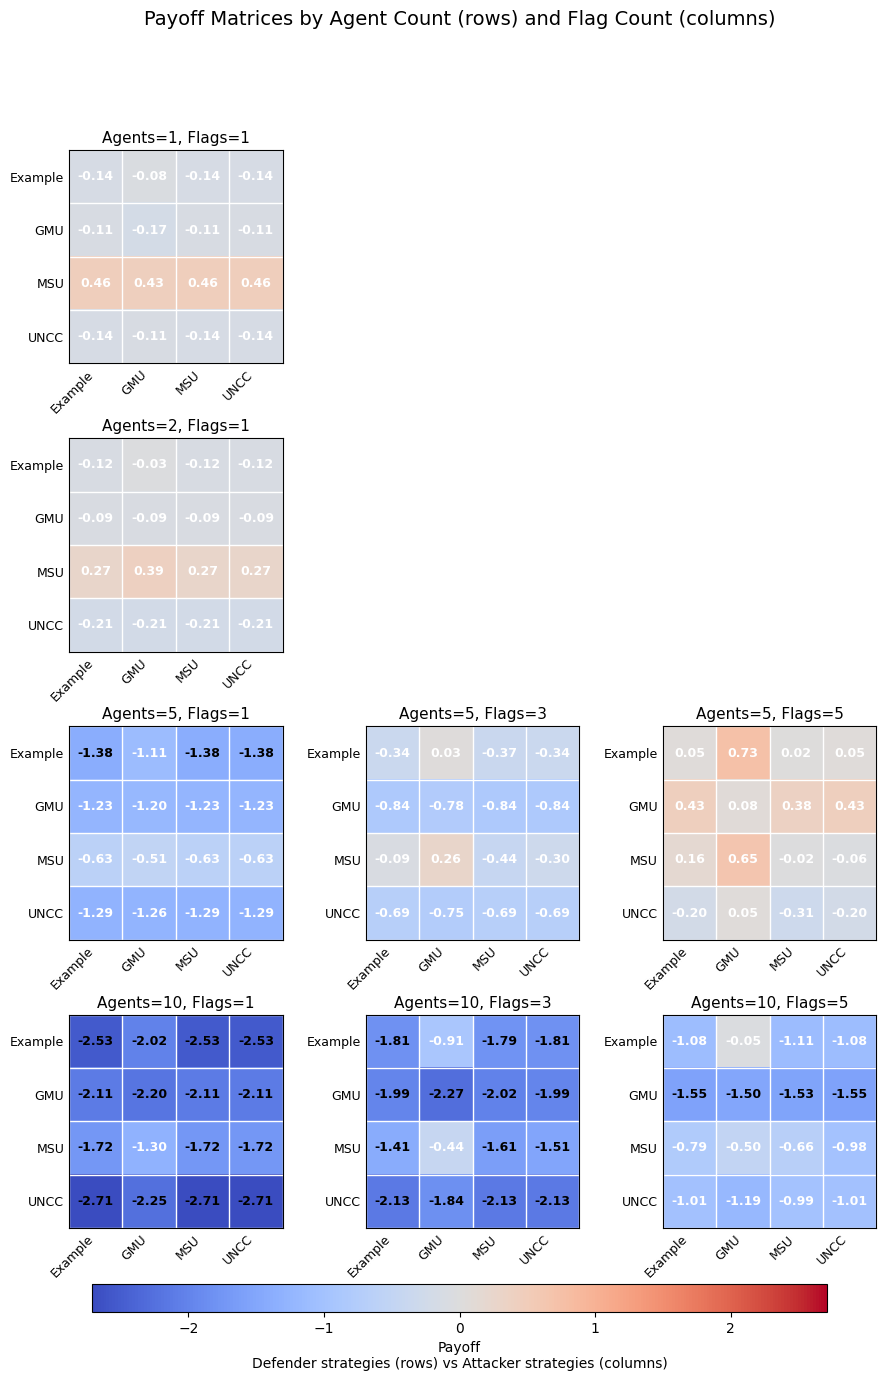

In [15]:
import lib.time_logger as TLOG
from lib.core import *
import os
import json
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.colors as mcolors

DATA_PATH = os.path.join("data", "result", "")

def extract_setup_key(metadata):
    """Extract only the setup parameters from metadata, excluding strategies."""
    setup_params = {}
    for key, value in metadata.items():
        if key not in ['attacker_strategy', 'defender_strategy']:
            setup_params[key] = value
    return json.dumps(setup_params, sort_keys=True)

def create_strategy_matrix():
    """Group files by unique setups and create matrices of attacker vs defender strategies."""
    print(f"Reading JSON files from: {DATA_PATH}")
    
    # Check if directory exists
    if not os.path.exists(DATA_PATH):
        print(f"Directory {DATA_PATH} does not exist.")
        return {}, set(), set()
    
    # Data structures to store results by setup and strategies
    setups = {}  # Will store {setup_key: {(attacker, defender): [stats]}}
    
    # Collect all unique attacker and defender strategies
    all_attackers = set()
    all_defenders = set()
    
    # Process all JSON files
    for filename in os.listdir(DATA_PATH):
        if not filename.endswith(".json"):
            continue
            
        filepath = os.path.join(DATA_PATH, filename)
        
        # Skip empty files
        if os.path.getsize(filepath) == 0:
            print(f"File {filename} is empty. Skipping.")
            continue
            
        try:
            # Create TimeLogger instance and read the file
            logger = TLOG.TimeLogger(name=filename)
            logger.path = DATA_PATH
            logger.read_from_file(filename)
            
            # Get metadata
            metadata = logger.get_metadata()
            
            # Skip if missing critical metadata
            if 'attacker_strategy' not in metadata or 'defender_strategy' not in metadata:
                print(f"File {filename} is missing strategy information. Skipping.")
                continue
            
            # Extract setup key (everything except strategies)
            setup_key = extract_setup_key(metadata)
            
            # Extract strategy info
            attacker = metadata.get('attacker_strategy')
            defender = metadata.get('defender_strategy')
            
            # Add to our sets of all strategies
            all_attackers.add(attacker)
            all_defenders.add(defender)
            
            # Initialize setup entry if needed
            if setup_key not in setups:
                setups[setup_key] = {}
            
            # Get strategy pair key
            strategy_pair = (attacker, defender)
            
            # Extract summary records
            summary_records = logger.extract_summary()
            
            # If there are summary records, add them to the appropriate group
            if summary_records:
                for summary in summary_records:
                    # Check if it has the keys we're interested in
                    if any(key in summary for key in ['payoff', 'time', 'total_captures', 'total_tags']):
                        if strategy_pair not in setups[setup_key]:
                            setups[setup_key][strategy_pair] = []
                        setups[setup_key][strategy_pair].append(summary)
            
        except Exception as e:
            print(f"Error processing file {filename}: {str(e)}")
    
    # For each setup, calculate averages for each strategy pair
    results = {}
    
    for setup_key, strategy_data in setups.items():
        setup_dict = json.loads(setup_key)
        
        # Create a strategy matrix for this setup
        attackers = sorted(all_attackers)
        defenders = sorted(all_defenders)
        
        # Create a matrix for payoff
        payoff_matrix = pd.DataFrame(index=defenders, columns=attackers)
        
        # Fill the matrices
        for (attacker, defender), summaries in strategy_data.items():
            # Skip pairs that don't have summary data
            if not summaries:
                continue
                
            # Calculate average payoff
            payoff_values = [s.get('payoff', 0) for s in summaries if 'payoff' in s]
            if payoff_values:
                payoff_matrix.loc[defender, attacker] = round(sum(payoff_values) / len(payoff_values), 2)
        
        # Store results for this setup
        results[setup_key] = {
            'setup': setup_dict,
            'payoff_matrix': payoff_matrix
        }
    
    return results, all_attackers, all_defenders

def organize_by_agents_and_flags(results):
    """
    Organize results by agent numbers and flag numbers.
    Returns a dictionary with (agent_num, flag_num) as keys.
    """
    organized_results = {}
    
    for setup_key, data in results.items():
        setup = data['setup']
        
        # Extract agent and flag numbers
        agent_num = setup.get('attacker_num')
        flag_num = setup.get('flag_num')
        
        # Skip if missing necessary information
        if agent_num is None or flag_num is None:
            continue
        
        # Convert to integers if they're strings
        if isinstance(agent_num, str):
            agent_num = int(agent_num)
        if isinstance(flag_num, str):
            flag_num = int(flag_num)
        
        # Store the result
        key = (agent_num, flag_num)
        if key not in organized_results:
            organized_results[key] = []
        
        organized_results[key].append({
            'setup': setup,
            'payoff_matrix': data['payoff_matrix']
        })
    
    return organized_results

def create_payoff_matrix_visualization(organized_results):
    """
    Create a clean matrix of matrices focused on payoff values,
    where rows are agent numbers and columns are flag numbers.
    """
    if not organized_results:
        print("No results to visualize.")
        return
    
    # Find the range of agent and flag numbers
    agent_nums = sorted(set(key[0] for key in organized_results.keys()))
    flag_nums = sorted(set(key[1] for key in organized_results.keys()))
    
    n_agents = len(agent_nums)
    n_flags = len(flag_nums)

    cell_size = 3.5  # or 2.5, depending on how large you want each subplot
    fig_width = max(cell_size * n_flags, 8)
    fig_height = max(cell_size * n_agents, 6)
    
    # Create figure
    fig = plt.figure(figsize=(fig_width, fig_height))
    
    # Create a grid of subplots with specified spacing
    gs = gridspec.GridSpec(n_agents, n_flags, figure=fig, wspace=0.35, hspace=0.35)

    
    # Create a custom diverging colormap centered at 0
    cmap = plt.cm.coolwarm  # Use standard matplotlib colormap
    
    # Find global min and max payoff for consistent color scale
    all_payoffs = []
    
    for results_list in organized_results.values():
        for result in results_list:
            matrix = result['payoff_matrix']
            # Use pandas to filter numeric values safely
            numeric_values = matrix.stack().dropna().astype(float).tolist()
            all_payoffs.extend(numeric_values)
    
    if all_payoffs:
        vmin = min(all_payoffs)
        vmax = max(all_payoffs)
    else:
        vmin, vmax = -1, 1
    
    # Ensure scale is symmetric around 0 if both positive and negative values exist
    if vmin < 0 and vmax > 0:
        abs_max = max(abs(vmin), abs(vmax))
        vmin, vmax = -abs_max, abs_max
    
    # Plot each matrix
    for i in agent_nums:
        for j in flag_nums:
                
            key = (i, j)
            if key not in organized_results:
                continue
                
            # Get the first result for this configuration
            result = organized_results[key][0]
            payoff_matrix = result['payoff_matrix']
            
            # Skip empty matrices
            if payoff_matrix.empty:
                continue
            
            # Get shortened strategy names for better display
            def shorten_name(name):
                if "_" in name:
                    # Split by underscore and take first part
                    return name.split("_")[0]
                elif len(name) > 8:
                    # Truncate long names
                    return name[:8]
                return name
            
            # Create shortened labels
            short_col_labels = [shorten_name(col) for col in payoff_matrix.columns]
            short_row_labels = [shorten_name(row) for row in payoff_matrix.index]
            
            # Create subplot
            ax = plt.subplot(gs[agent_nums.index(i), flag_nums.index(j)])
            
            # Create a safe numerical representation for imshow
            data = np.zeros(payoff_matrix.shape)
            for di, defender in enumerate(payoff_matrix.index):
                for ai, attacker in enumerate(payoff_matrix.columns):
                    value = payoff_matrix.loc[defender, attacker]
                    if pd.notna(value):
                        try:
                            data[di, ai] = float(value)
                        except (ValueError, TypeError):
                            # If conversion fails, use a default value
                            data[di, ai] = 0
                    else:
                        data[di, ai] = np.nan
            
            # Create heatmap
            im = ax.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax)
            
            # Add text annotations
            for di, defender in enumerate(payoff_matrix.index):
                for ai, attacker in enumerate(payoff_matrix.columns):
                    value = payoff_matrix.loc[defender, attacker]
                    if pd.notna(value):
                        try:
                            float_value = float(value)
                            # Determine text color based on value
                            normalized_value = (float_value - vmin) / (vmax - vmin)
                            text_color = 'white' if 0.25 < normalized_value < 0.75 else 'black'
                            
                            ax.text(ai, di, f"{float_value:.2f}", ha="center", va="center", 
                                   color=text_color, fontweight='bold', fontsize=9)
                        except (ValueError, TypeError):
                            # Skip text for non-numeric values
                            pass
            
            # Set title and customize appearance
            ax.set_title(f"Agents={i}, Flags={j}", fontsize=11, pad=5)
            
            # Set tick labels with shorter names
            ax.set_xticks(np.arange(len(payoff_matrix.columns)))
            ax.set_yticks(np.arange(len(payoff_matrix.index)))
            ax.set_xticklabels(short_col_labels, fontsize=9, rotation=45, ha='right')
            ax.set_yticklabels(short_row_labels, fontsize=9)
            
            # Turn off tick marks
            ax.tick_params(axis='both', which='both', length=0)
            
            # Add grid lines between cells
            ax.set_xticks(np.arange(-.5, len(payoff_matrix.columns), 1), minor=True)
            ax.set_yticks(np.arange(-.5, len(payoff_matrix.index), 1), minor=True)
            ax.grid(which='minor', color='w', linestyle='-', linewidth=1)
    
    # Add a title for the entire figure
    plt.suptitle("Payoff Matrices by Agent Count (rows) and Flag Count (columns)", 
                fontsize=14, y=0.98)
    
    # Add a single colorbar for the entire figure - horizontal at the bottom
    cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.02])  # [left, bottom, width, height]
    cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
    cbar.set_label('Payoff')
    
    # Add a legend for strategy types
    fig.text(0.5, 0.01, 
             "Defender strategies (rows) vs Attacker strategies (columns)",
             ha='center', fontsize=10)
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0.08, 1, 0.95])
    
    # Save figure
    plt.savefig('payoff_matrix_of_matrices.png', dpi=300, bbox_inches='tight')
    print("Visualization saved as payoff_matrix_of_matrices.png")
    
    # Show plot
    plt.show()
    
    return fig

# Execute the functions
results, all_attackers, all_defenders = create_strategy_matrix()

# Display summary statistics
print(f"\nFound {len(results)} unique game setups.")
print(f"Found {len(all_attackers)} unique attacker strategies: {sorted(all_attackers)}")
print(f"Found {len(all_defenders)} unique defender strategies: {sorted(all_defenders)}")

# Organize results by agent and flag numbers
organized_results = organize_by_agents_and_flags(results)

# Create payoff-focused visualization
try:
    fig = create_payoff_matrix_visualization(organized_results)
except Exception as e:
    print(f"Error creating visualization: {str(e)}")
    # Create a simpler version without the problematic parts
    print("Attempting to create a simpler visualization...")
    
    # Create a figure with a text-only representation
    plt.figure(figsize=(10, 8))
    plt.text(0.5, 0.5, "Error generating heatmap visualization.\nCheck data types in your matrices.",
             ha='center', va='center', fontsize=14)
    plt.axis('off')
    plt.savefig('payoff_matrix_error.png')
    plt.show()

Reading JSON files from: data/result/

Found 8 unique game setups.
Found 4 unique attacker strategies: ['Example_Attacker', 'GMU_Attacker', 'MSU_Attacker', 'UNCC_Attacker']
Found 4 unique defender strategies: ['Example_Defender', 'GMU_Defender', 'MSU_Defender', 'UNCC_Defender']


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/nashpy/algorithms/support_enumeration.py:260: RuntimeWarning: 
An even number of (4) equilibria was returned. This
indicates that the game is degenerate. Consider using another algorithm
to investigate.
                  
  warnings.warn(warning, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/nashpy/algorithms/support_enumeration.py:260: RuntimeWarning: 
An even number of (0) equilibria was returned. This
indicates that the game is degenerate. Consider using another algorithm
to investigate.
                  
  warnings.warn(warning, RuntimeWarning)


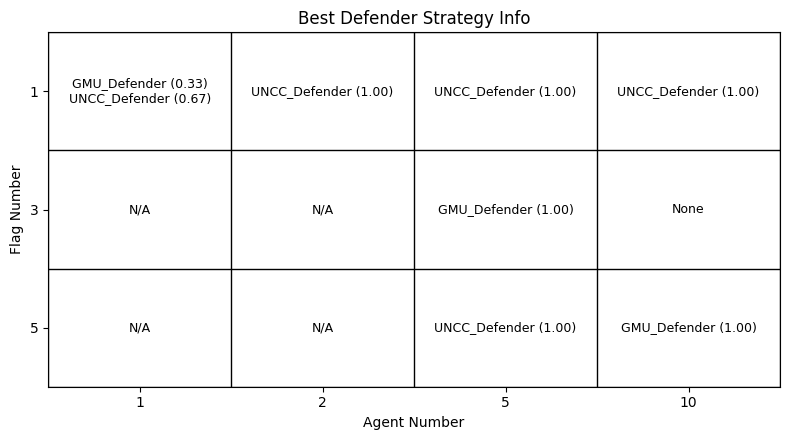

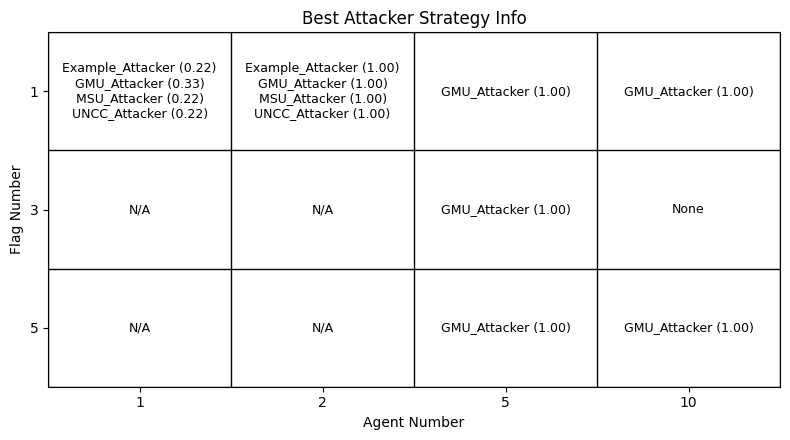

In [10]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import gridspec
import nashpy as nash
import lib.time_logger as TLOG
from lib.core import *

# Directory containing the JSON log files
DATA_PATH = os.path.join("data", "result", "")

# ============== Data Loading & Matrix Construction ==============
def extract_setup_key(metadata):
    """Extract only the setup parameters from metadata, excluding strategies."""
    setup_params = {}
    for key, value in metadata.items():
        if key not in ['attacker_strategy', 'defender_strategy']:
            setup_params[key] = value
    return json.dumps(setup_params, sort_keys=True)

def create_strategy_matrix():
    """Group files by unique setups and create matrices of attacker vs defender strategies."""
    print(f"Reading JSON files from: {DATA_PATH}")
    if not os.path.exists(DATA_PATH):
        print(f"Directory {DATA_PATH} does not exist.")
        return {}, set(), set()
    
    setups = {}
    all_attackers = set()
    all_defenders = set()
    
    for filename in os.listdir(DATA_PATH):
        if not filename.endswith(".json"):
            continue
        filepath = os.path.join(DATA_PATH, filename)
        if os.path.getsize(filepath) == 0:
            print(f"File {filename} is empty. Skipping.")
            continue
        try:
            logger = TLOG.TimeLogger(name=filename)
            logger.path = DATA_PATH
            logger.read_from_file(filename)
            metadata = logger.get_metadata()
            if 'attacker_strategy' not in metadata or 'defender_strategy' not in metadata:
                print(f"File {filename} is missing strategy information. Skipping.")
                continue
            setup_key = extract_setup_key(metadata)
            attacker = metadata.get('attacker_strategy')
            defender = metadata.get('defender_strategy')
            all_attackers.add(attacker)
            all_defenders.add(defender)
            if setup_key not in setups:
                setups[setup_key] = {}
            strategy_pair = (attacker, defender)
            summary_records = logger.extract_summary()
            if summary_records:
                for summary in summary_records:
                    if any(key in summary for key in ['payoff', 'time', 'total_captures', 'total_tags']):
                        if strategy_pair not in setups[setup_key]:
                            setups[setup_key][strategy_pair] = []
                        setups[setup_key][strategy_pair].append(summary)
        except Exception as e:
            print(f"Error processing file {filename}: {str(e)}")
    
    results = {}
    for setup_key, strategy_data in setups.items():
        setup_dict = json.loads(setup_key)
        attackers = sorted(all_attackers)
        defenders = sorted(all_defenders)
        # Create a payoff matrix (rows: defender, cols: attacker)
        payoff_matrix = pd.DataFrame(index=defenders, columns=attackers)
        for (attacker, defender), summaries in strategy_data.items():
            if not summaries:
                continue
            payoff_values = [s.get('payoff', 0) for s in summaries if 'payoff' in s]
            if payoff_values:
                payoff_matrix.loc[defender, attacker] = round(sum(payoff_values)/len(payoff_values), 2)
        results[setup_key] = {'setup': setup_dict, 'payoff_matrix': payoff_matrix}
    return results, all_attackers, all_defenders

def organize_by_agents_and_flags(results):
    """
    Organize results by agent numbers and flag numbers.
    Returns a dictionary with keys (agent_num, flag_num).
    """
    organized_results = {}
    for setup_key, data in results.items():
        setup = data['setup']
        agent_num = setup.get('attacker_num')
        flag_num = setup.get('flag_num')
        if agent_num is None or flag_num is None:
            continue
        agent_num = int(agent_num)
        flag_num = int(flag_num)
        key = (agent_num, flag_num)
        if key not in organized_results:
            organized_results[key] = []
        organized_results[key].append({'setup': setup, 'payoff_matrix': data['payoff_matrix']})
    return organized_results

# ============== Nash Equilibrium & Best Strategy Computation ==============
def compute_best_strategies(payoff_matrix):
    """
    Using NashPy, compute the equilibrium for a zero-sum game defined by the payoff matrix.
    The game is defined as Game(-A, A) so that the defender (rows) minimizes and the attacker (columns) maximizes.
    
    For pure equilibria, every best strategy gets a score of 1.
    For mixed equilibria, all strategies with nonzero probability are shown with their averaged probability.
    
    Returns:
      best_defender: dict mapping defender strategy to its score (1 for pure, or the averaged probability for mixed)
      best_attacker: dict mapping attacker strategy to its score (1 for pure, or the averaged probability for mixed)
      avg_row: averaged equilibrium distribution for defender strategies (None in pure case)
      avg_col: averaged equilibrium distribution for attacker strategies (None in pure case)
    """
    # Convert payoff_matrix to a numeric numpy array.
    A = payoff_matrix.astype(float).values
    game = nash.Game(-A, A)
    equilibria = list(game.support_enumeration())
    if not equilibria:
        return {}, {}, None, None

    # Check if all equilibria are pure:
    pure_equilibria = True
    for row_eq, col_eq in equilibria:
        if not (np.count_nonzero(np.isclose(row_eq, 1)) == 1 and np.count_nonzero(~np.isclose(row_eq, 0)) == 1):
            pure_equilibria = False
            break
        if not (np.count_nonzero(np.isclose(col_eq, 1)) == 1 and np.count_nonzero(~np.isclose(col_eq, 0)) == 1):
            pure_equilibria = False
            break

    if pure_equilibria:
        best_defender = {}
        best_attacker = {}
        # For each equilibrium, record the pure strategies.
        for row_eq, col_eq in equilibria:
            idxs_def = np.where(np.isclose(row_eq, 1))[0]
            for idx in idxs_def:
                strat = payoff_matrix.index[idx]
                best_defender[strat] = 1
            idxs_att = np.where(np.isclose(col_eq, 1))[0]
            for idx in idxs_att:
                strat = payoff_matrix.columns[idx]
                best_attacker[strat] = 1
        return best_defender, best_attacker, None, None
    else:
        # Mixed equilibrium: average all equilibrium vectors.
        row_vecs = []
        col_vecs = []
        for row_eq, col_eq in equilibria:
            row_vecs.append(row_eq)
            col_vecs.append(col_eq)
        avg_row = np.mean(row_vecs, axis=0)
        avg_col = np.mean(col_vecs, axis=0)
        
        # For mixed equilibria, include all strategies that have a nonzero probability.
        best_defender = {strategy: prob 
                         for strategy, prob in zip(payoff_matrix.index, avg_row) 
                         if prob > 0}
        best_attacker = {strategy: prob 
                         for strategy, prob in zip(payoff_matrix.columns, avg_col) 
                         if prob > 0}
        
        return best_defender, best_attacker, avg_row, avg_col



def compute_best_strategy_info(organized_results):
    """
    For each (agent, flag) configuration, compute the best (equilibrium) strategies for both defender and attacker.
    Returns two dictionaries:
      best_defender_info[(agent, flag)] = {strategy: probability, ...}
      best_attacker_info[(agent, flag)] = {strategy: probability, ...}
    """
    best_defender_info = {}
    best_attacker_info = {}
    for key, results_list in organized_results.items():
        # For simplicity, use the first payoff matrix for the configuration.
        payoff_matrix = results_list[0]['payoff_matrix']
        if payoff_matrix.empty:
            continue
        best_def, best_att, _, _ = compute_best_strategies(payoff_matrix)
        best_defender_info[key] = best_def
        best_attacker_info[key] = best_att
    return best_defender_info, best_attacker_info

# ============== Visualization ==============
def mix_colors(color_list):
    """Average the RGB channels; sum alpha (capped at 1)."""
    if not color_list:
        return (1,1,1,0)
    r = np.mean([c[0] for c in color_list])
    g = np.mean([c[1] for c in color_list])
    b = np.mean([c[2] for c in color_list])
    a = min(sum(c[3] for c in color_list), 1.0)
    return (r, g, b, a)

# Define fixed transparent colors for strategies.
DEFENDER_COLORS = {
    'GMU': (1, 0, 0, 0.3),    # red
    'UNCC': (0, 0, 1, 0.3),   # blue
    'MSU': (0, 1, 0, 0.3),    # green
    'Naïve': (1, 1, 0, 0.3)   # yellow
}
ATTACKER_COLORS = {
    'Naïve': (0, 1, 0, 0.3),  # green
    'GMU': (1, 0, 0, 0.3),    # red
    'UNCC': (0, 0, 1, 0.3),   # blue
    'MSU': (1, 1, 0, 0.3)     # yellow
}

def plot_policy_info_grid(policy_info, role, color_dict, organized_results):
    """
    Create a grid plot where x-axis is agent number and y-axis is flag number.
    For each cell (configuration), display the best strategy(ies) with their equilibrium probability.
    """
    agent_nums = sorted(set(k[0] for k in organized_results.keys()))
    flag_nums = sorted(set(k[1] for k in organized_results.keys()))
    
    fig, ax = plt.subplots(figsize=(len(agent_nums)*2, len(flag_nums)*1.5))
    
    # Set axis so each cell is 1×1
    ax.set_xlim(0, len(agent_nums))
    ax.set_ylim(0, len(flag_nums))
    ax.invert_yaxis()  # So flag numbers increase upwards
    
    # Tick labels
    ax.set_xticks(np.arange(len(agent_nums)) + 0.5)
    ax.set_xticklabels(agent_nums)
    ax.set_yticks(np.arange(len(flag_nums)) + 0.5)
    ax.set_yticklabels(flag_nums)
    
    # Draw grid lines
    for i in range(len(agent_nums) + 1):
        ax.axvline(i, color='black', linewidth=1)
    for j in range(len(flag_nums) + 1):
        ax.axhline(j, color='black', linewidth=1)
    
    for i, f in enumerate(flag_nums):
        for j, a in enumerate(agent_nums):
            key = (a, f)
            if key in policy_info:
                info = policy_info[key]  # best strategy info for that configuration
                if info:
                    annot_lines = [f"{strat} ({prob:.2f})" for strat, prob in info.items()]
                    annot_text = "\n".join(annot_lines)
                    # Use the colors of the strategies to fill background
                    cell_colors = [color_dict.get(strat, (1,1,1,0)) for strat in info.keys()]
                    bg_color = mix_colors(cell_colors)
                else:
                    annot_text = "None"
                    bg_color = (1,1,1,0)
            else:
                annot_text = "N/A"
                bg_color = (1,1,1,0)
            
            # Draw background rectangle
            rect = Rectangle((j, i), 1, 1, facecolor=bg_color, edgecolor='none')
            ax.add_patch(rect)
            
            # Place text in center
            ax.text(j + 0.5, i + 0.5, annot_text,
                    ha='center', va='center',
                    fontsize=9, wrap=True)
    
    ax.set_xlabel("Agent Number")
    ax.set_ylabel("Flag Number")
    ax.set_title(f"Best {role.capitalize()} Strategy Info")
    plt.tight_layout()
    plt.savefig(f"{role}_best_policy_info_grid.png", dpi=300)
    plt.show()

# ============== MAIN EXECUTION ==============
results, all_attackers, all_defenders = create_strategy_matrix()
print(f"\nFound {len(results)} unique game setups.")
print(f"Found {len(all_attackers)} unique attacker strategies: {sorted(all_attackers)}")
print(f"Found {len(all_defenders)} unique defender strategies: {sorted(all_defenders)}")

organized_results = organize_by_agents_and_flags(results)

# Compute best strategy info for each configuration using NashPy equilibrium
best_defender_info, best_attacker_info = compute_best_strategy_info(organized_results)

# Plot grid for defender (row minimizer)
plot_policy_info_grid(best_defender_info, "defender", DEFENDER_COLORS, organized_results)
# Plot grid for attacker (column maximizer)
plot_policy_info_grid(best_attacker_info, "attacker", ATTACKER_COLORS, organized_results)
